# Does alcohol Consumption Make our Sleep Less Efficient?

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.frame import DataFrame
from IPython.display import display
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter, MultipleLocator

 ### 1. ensure data types are appropriate and there is no missing data

In [90]:
df = pd.read_csv('/Users/amit/Documents/Code/python/life-expectancy/life-expectancy.csv', dtype={'Country':'category', 'Status':'category'})

n_rows, n_columns = df.shape 
total_data = n_rows * n_columns
print(f'total rows: {n_rows} \ntotal columns: {n_columns} \ntotal data: {total_data}')

df.head()

total rows: 2938 
total columns: 22 
total data: 64636


,Country,Year,Status,Lifeexpectancy,AdultMortality,infantdeaths,Alcohol,percentageexpenditure,HepatitisB,Measles,...,Polio,Totalexpenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness1-19years,thinness5-9years,Incomecompositionofresources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Country                       2938 non-null   category
 1   Year                          2938 non-null   int64   
 2   Status                        2938 non-null   category
 3   Lifeexpectancy                2928 non-null   float64 
 4   AdultMortality                2928 non-null   float64 
 5   infantdeaths                  2938 non-null   int64   
 6   Alcohol                       2744 non-null   float64 
 7   percentageexpenditure         2938 non-null   float64 
 8   HepatitisB                    2385 non-null   float64 
 9   Measles                       2938 non-null   int64   
 10  BMI                           2904 non-null   float64 
 11  under-fivedeaths              2938 non-null   int64   
 12  Polio                         2919 non-null   fl

- Country's Dtype was originally object, it has been changed to categorical data
- Status's Dtype was originally object, it has been changed to categorical data


In [92]:
print('number of nulls is: ', df.isnull().sum().sum())
df.isnull().sum()

number of nulls is:  2563


Country                           0
Year                              0
Status                            0
Lifeexpectancy                   10
AdultMortality                   10
infantdeaths                      0
Alcohol                         194
percentageexpenditure             0
HepatitisB                      553
Measles                           0
BMI                              34
under-fivedeaths                  0
Polio                            19
Totalexpenditure                226
Diphtheria                       19
HIV/AIDS                          0
GDP                             448
Population                      652
thinness1-19years                34
thinness5-9years                 34
Incomecompositionofresources    167
Schooling                       163
dtype: int64

the percentage of missing data is:
$$
\frac{2563}{64636} \cdot 100 \approx 4\%
$$
which is less then 5%, so __there is no need for imputation__, this percent won't effect the overall data.

In [93]:
df.dropna(inplace=True)

### 2. statistical summaries

In [94]:
def summary_stats(dataframe: DataFrame, numeric_only=True, style=True):
    if numeric_only:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe[numeric_cols].describe().T
        summary["variance"] = dataframe[numeric_cols].var()
        if style:
            summary = summary.style.format("{:.2f}").background_gradient(cmap="Oranges", axis=1, subset=summary.columns.drop("count"))
    else:
        numeric_cols = dataframe.select_dtypes(include=['number']).columns
        summary = dataframe.describe(exclude="number")
    return summary



numeric_cols_summary = summary_stats(df, style=True)
category_cols_summary = summary_stats(df, numeric_only=False)

display(numeric_cols_summary)
display(category_cols_summary)

,count,mean,std,min,25%,50%,75%,max,variance
Year,1649.00,2007.84,4.09,2000.00,2005.00,2008.00,2011.00,2015.00,16.71
Lifeexpectancy,1649.00,69.30,8.80,44.00,64.40,71.70,75.00,89.00,77.38
AdultMortality,1649.00,168.22,125.31,1.00,77.00,148.00,227.00,723.00,15702.70
infantdeaths,1649.00,32.55,120.85,0.00,1.00,3.00,22.00,1600.00,14604.04
Alcohol,1649.00,4.53,4.03,0.01,0.81,3.79,7.34,17.87,16.23
percentageexpenditure,1649.00,698.97,1759.23,0.00,37.44,145.10,509.39,18961.35,3094887.86
HepatitisB,1649.00,79.22,25.60,2.00,74.00,89.00,96.00,99.00,655.60
Measles,1649.00,2224.49,10085.80,0.00,0.00,15.00,373.00,131441.00,101723402.36
BMI,1649.00,38.13,19.75,2.00,19.50,43.70,55.80,77.10,390.23
under-fivedeaths,1649.00,44.22,162.90,0.00,1.00,4.00,29.00,2100.00,26535.76


,Country,Status
count,1649,1649
unique,133,2
top,Afghanistan,Developing
freq,16,1407


All of the statistics that have a very high variance, probably have a lot of outliers that have BIG impact on our data, we will remove them.<br/><br/><sub><sup>__but that will be handled in section 4__</sup></sub>

### 3. Outcome and Input Variables
__Outcome variable__: Life expectancy

__Input Variables__:
1. Alcohol
2. BMI
3. Schooling
4. Income composition of resources

### 4. Find and remove outliers

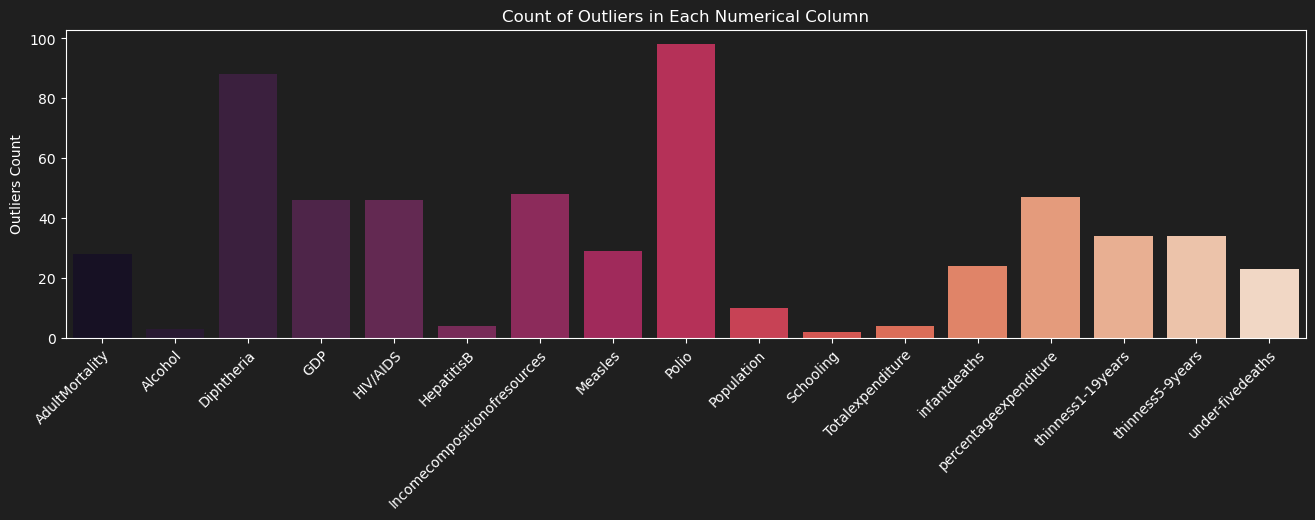

In [95]:
def find_outliers(column):
    mean = df[column].mean()
    std_dev = df[column].std()
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()
    outliers['Column'] = column
    return outliers

numeric_df_columns = df.select_dtypes(include=['number']).columns
all_outliers = pd.concat([find_outliers(col) for col in numeric_df_columns])
outliers_count = all_outliers.groupby('Column').size().reset_index(name='OutliersCount')

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
        'axes.edgecolor': 'white',
    })

    plt.figure(figsize=(16, 4))
    bar_plot = sns.barplot(x='Column', y='OutliersCount', data=outliers_count, palette='rocket')
    plt.title('Count of Outliers in Each Numerical Column')
    plt.xlabel('')
    plt.ylabel('Outliers Count')
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor') 


    plt.show()

In [96]:
def remove_outliers_std(df, column):
    mean = df[column].mean()
    std_dev = df[column].std()
    lower_bound = mean - 3 * std_dev
    upper_bound = mean + 3 * std_dev
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

numeric_df = df.select_dtypes(include=['number'])
numeric_df_without_outliers = numeric_df.copy()
for col in numeric_df_without_outliers.columns:
    numeric_df_without_outliers = remove_outliers_std(numeric_df_without_outliers, col)

print(f'Rows before removing outliers: {numeric_df.shape[0]}')
print(f'Rows after removing outliers: {numeric_df_without_outliers.shape[0]}')

Rows before removing outliers: 1649
Rows after removing outliers: 1162


So we got to the point... does alcohol consumption really make our sleep less efficient?
### 5. test the hypothesis

$$H_0 = \text{Alcohol consumption affects sleep efficiency}$$
$$H_1 = \text{Alcohol consumption does not affect sleep efficiency}$$

We will choose a significance value of 0.95; meaning a p-value of 0.05
<br/>(but we will also show results for p-values: 0.1, 0.005)

#### first test - a-parametric Wilcoxon

In [109]:
t1_statistic, p1_value = stats.wilcoxon(numeric_df_without_outliers['Schooling'], numeric_df_without_outliers['Lifeexpectancy'])
t2_statistic, p2_value = stats.wilcoxon(numeric_df_without_outliers['Incomecompositionofresources'], numeric_df_without_outliers['Lifeexpectancy'])
t3_statistic, p3_value = stats.wilcoxon(numeric_df_without_outliers['Alcohol'], numeric_df_without_outliers['Lifeexpectancy'])
t4_statistic, p4_value = stats.wilcoxon(numeric_df_without_outliers['BMI'], numeric_df_without_outliers['Lifeexpectancy'])

print('Wilcoxon test results\n')
print("1. Schooling - Life expectancy:\n\tstatistic:", t1_statistic, ", p-value:", p1_value)
print("2. Income composition of resources - Life expectancy:\n\tstatistic:", t2_statistic, ", p-value:", p2_value)
print("3. Alcohol - Life expectancy:\n\tstatistic:", t3_statistic, ", p-value:", p3_value)
print("4. BMI - Life expectancy:\n\tstatistic:", t4_statistic, ", p-value:", p4_value)

Wilcoxon test results

1. Schooling - Life expectancy:
	statistic: 0.0 , p-value: 1.2734728295166318e-191
2. Income composition of resources - Life expectancy:
	statistic: 0.0 , p-value: 1.2764305039650971e-191
3. Alcohol - Life expectancy:
	statistic: 0.0 , p-value: 1.2762948764825957e-191
4. BMI - Life expectancy:
	statistic: 336.0 , p-value: 3.038170457279449e-191


### 6. extra information...

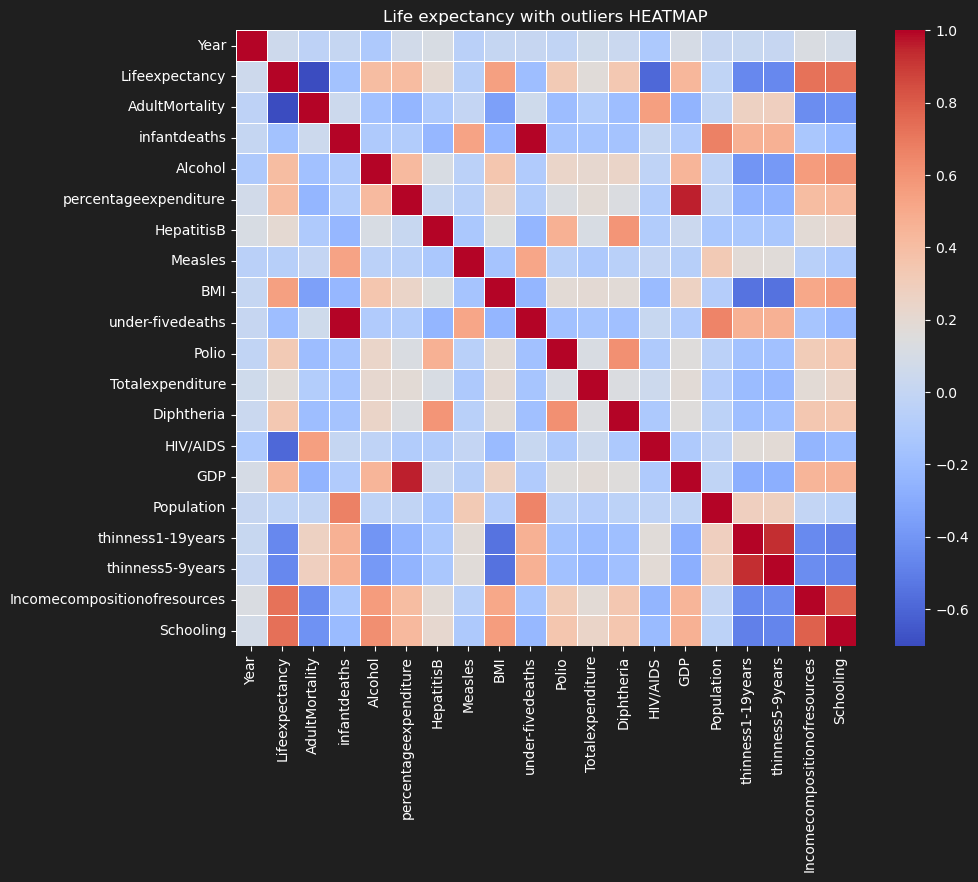

In [98]:
corr_matrix = numeric_df.corr()

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })

    plt.figure(figsize=(10, 8))
    plt.title('Life expectancy with outliers HEATMAP')
    sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5, annot_kws={"fontsize": 10}, fmt=".2f")        
    plt.show()


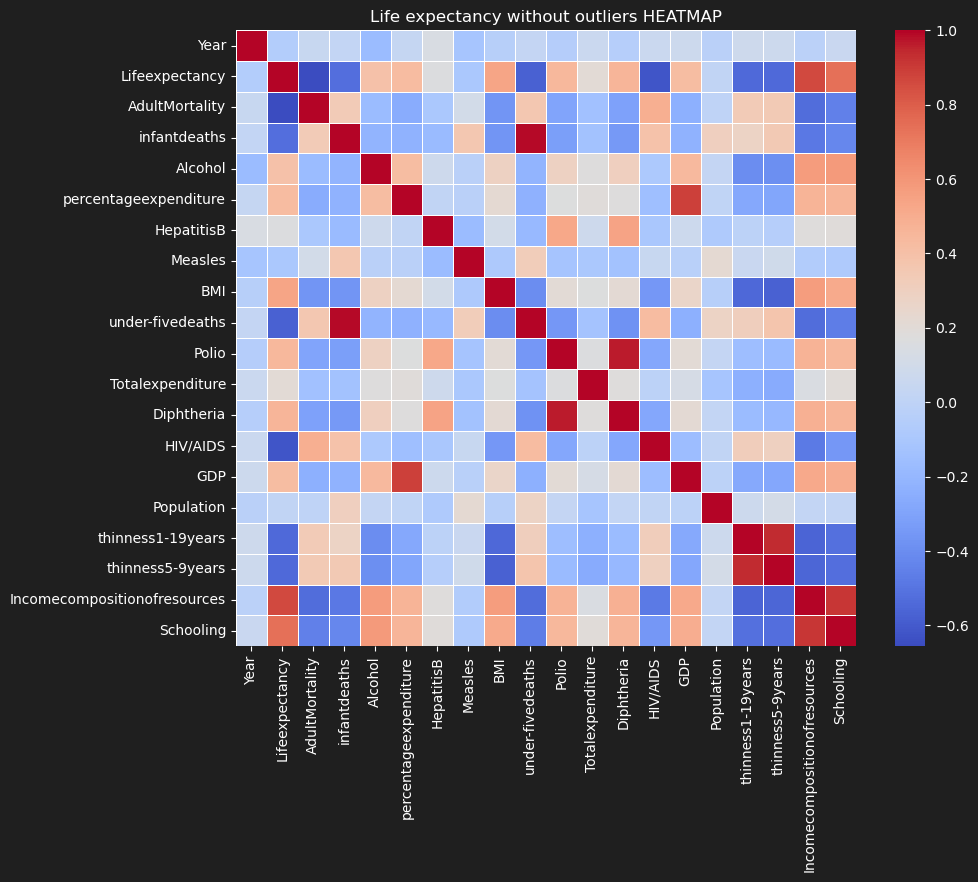

In [99]:
corr_matrix = numeric_df_without_outliers.corr()

with plt.style.context('dark_background'):
    plt.rcParams.update({
        'figure.facecolor': '#1f1f1f',
        'axes.facecolor': '#1f1f1f',
    })
    
    plt.figure(figsize=(10, 8))
    plt.title('Life expectancy without outliers HEATMAP')
    sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5, annot_kws={"fontsize": 10}, fmt=".2f")        
    plt.show()
